In [1]:
import numpy as np

from scipy.stats import norm
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt

In [2]:
def expected_improvement(x, model, evaluated_loss, greater_is_better=False, n_params=1):

    x_to_predict = x.reshape(-1, n_params) 
    
    # mu, sigma в зависимости от модели
    if model.__class__.__name__ == 'GaussianProcessRegressor':
        mu, sigma = model.predict(x_to_predict, return_std=True)

    elif model.__class__.__name__ == 'RandomForestRegressor':
        estimators = model.estimators_
        values = [est.predict(x_to_predict) for est in estimators]
        values = np.array(values)
        mu = np.mean(values, axis = 0)
        sigma = np.std(values, axis = 0)
    
    
    # Находим оптимальный лосс, из старых значений
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    # if False or 0 == -1, else = 1
    scaling_factor = (-1) ** (not greater_is_better)

    # игнор ошибок при делении
    with np.errstate(divide='ignore'):
        # Считаем З
        Z = scaling_factor * (mu - loss_optimum) / sigma
        
        # возвращает 100к експ емпрувментов
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0
        #print('Z_max', np.max(expected_improvement))        

    return -1 * expected_improvement


def bayesian_optimisation(model, n_iters, sample_loss, bounds, n_pre_samples=5,
                          random_search=False, epsilon=1e-7, greater_is_better=False):

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    # Стартовые точки
    for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
        # Делаем параметры, считаем функцию для них
        x_list.append(params)
        y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)


    for n in range(n_iters):
        model.fit(xp, yp)
        
        # Генерируем (random_search, len(params)) чисел в нашем промежутке
        x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))

        # считаем 100к ЕИ, берем наилучшее
        ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=greater_is_better, 
                                       n_params=n_params)
        next_sample = x_random[np.argmax(ei), :]
            
        # При частом попадании в одну область (епсилон) - тыкаем в рандом
        if np.any(np.abs(next_sample - xp) <= epsilon):
            #print(n, 'GONNA RNG')
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [3]:
def pltlist(topy, greater_is_better = False):
    plotlist = []
    y_max = 100

    for y in topy:
        if greater_is_better == True:
            if y > y_max:
                y_max = y
        else:
            if y < y_max:
                y_max = y
                
        plotlist.append(y_max)

    return np.array(plotlist)

# Rastrigin func

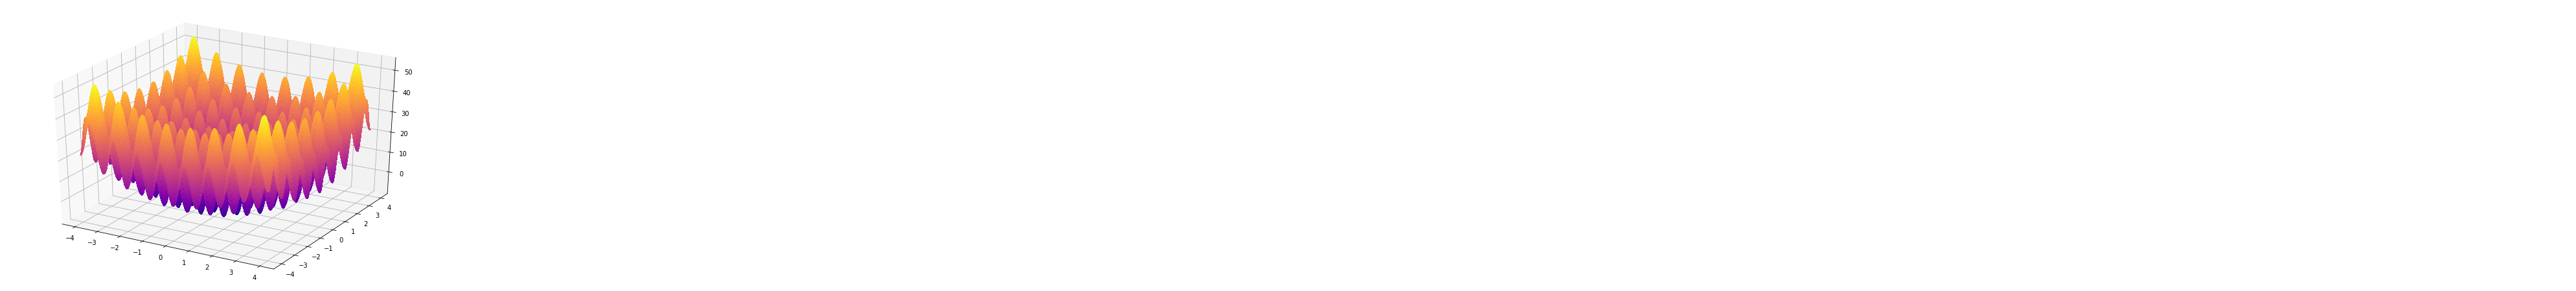

In [4]:
def rastrigin(*X, **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])

X = np.linspace(-4, 4, 200)    
Y = np.linspace(-4, 4, 200)    

X, Y = np.meshgrid(X, Y)
Z = rastrigin(X, Y, A=10)

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)
plt.show()

def rastrigin_loss(params):
    return rastrigin(params[0], params[1], A=10)

In [5]:
X = np.linspace(-4, 4, 201) 
Y = np.linspace(-4, 4, 201) 

# We need the cartesian combination of these two vectors
param_grid = np.array([[x, y] for y in Y for x in X]) 

real_loss_rastrigin = [rastrigin_loss(params) for params in param_grid] # считаем лосс для каждого

# The maximum is at:
param_grid[np.array(real_loss_rastrigin).argmin(), :]

array([0., 0.])

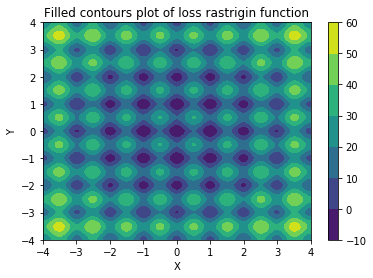

In [6]:
C, G = np.meshgrid(X, Y)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss_rastrigin).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss rastrigin function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [7]:
rastrigin_loss([0, 0])

-10.0

## SMBO

In [17]:
import sklearn.gaussian_process as gp

bounds = np.array([[-4, 4], [-4, 4]])

kernel = gp.kernels.Matern()
model_gp = gp.GaussianProcessRegressor(kernel=kernel,
                                    alpha=1e-5,
                                    n_restarts_optimizer=10,
                                    normalize_y=True)

y_mean = []
for i in range(30):
    xp_gp, yp_gp = bayesian_optimisation(model_gp, n_iters = 50, 
                               sample_loss=rastrigin_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000,
                               epsilon = 1e-4)
    y_mean.append(pltlist(yp_gp))

#print('min iter, min value:', yp_gp.argmin(), xp_gp[yp_gp.argmin()])
y_mean_gp = np.mean(y_mean, axis = 0)

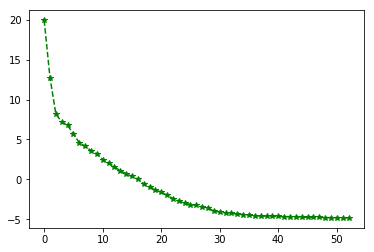

In [18]:
listy_gp = pltlist(y_mean_gp)
plt.plot(listy_gp, '*g--')
plt.show()

## SMAC

In [19]:
from sklearn.ensemble import RandomForestRegressor


model_rf = RandomForestRegressor(n_estimators = 200,
                              random_state = 42, max_depth = 15)
y_mean = []
for i in range(30):
    xp_rf, yp_rf = bayesian_optimisation(model_rf, n_iters=50, 
                               sample_loss=rastrigin_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000,
                               epsilon = 1e-4)
    y_mean.append(pltlist(yp_rf))
    
#print('min iter, min value:', yp_rf.argmin(), xp_rf[yp_rf.argmin()])
y_mean_rf = np.mean(y_mean, axis = 0)

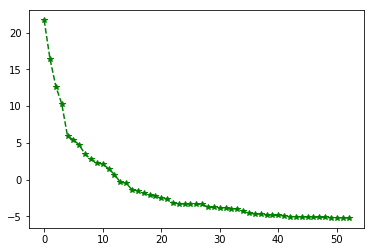

In [20]:
listy_rf = pltlist(y_mean_rf)
plt.plot(listy_rf, '*g--')
plt.show()

## Rand Search

In [12]:
def RandomSearch(func, bounds, n_iter = 20):
    x_list = []
    y_list = []
    
    for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_iter, bounds.shape[0])):
        x_list.append(params)
        y_list.append(func(params))
    x = np.array(x_list)
    y = np.array(y_list)
    return x, y

In [24]:
bounds = np.array([[-4, 4], [-4, 4]])

y_mean = []
for _ in range(30):
    x_rs, y_rs = RandomSearch(rastrigin_loss, bounds, n_iter = 53)
    
    y_mean.append(pltlist(y_rs))
    
y_mean_rs = np.mean(y_mean, axis = 0)

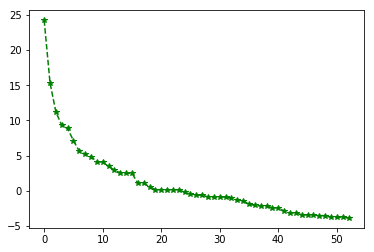

In [25]:
pltrngsearch = pltlist(y_mean_rs)
plt.plot(pltrngsearch, 'g*--')
plt.show()

## one graph

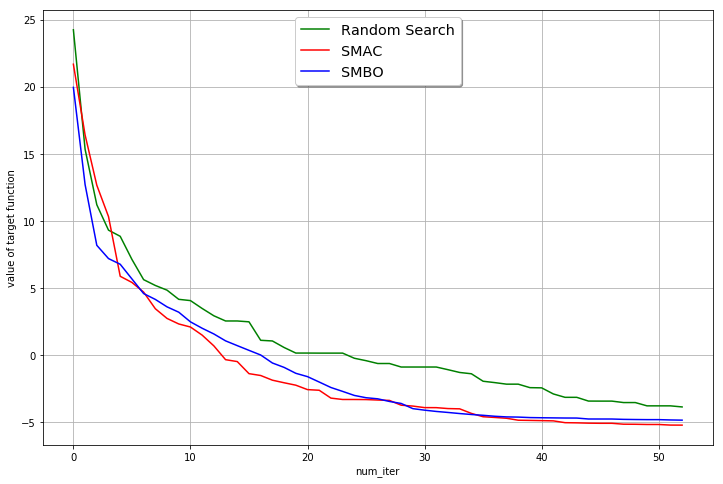

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(pltrngsearch, 'g', label='Random Search')
plt.plot(listy_rf, 'r', label='SMAC')
plt.plot(listy_gp, 'b', label='SMBO')

plt.xlabel('num_iter')
plt.ylabel('value of target function')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.grid()
plt.show()